Importing essential dependencies

In [60]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import ttest_ind, mannwhitneyu

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

pd.set_option('display.max_columns', None)
pd.set_option('display.width', 120)

import warnings
warnings.filterwarnings("ignore")


Part A: Data preparation

In [61]:
# Loading data and basic profiling
sentiment_df = pd.read_csv("fear_greed_index.csv")
trades_df = pd.read_csv("historical_data.csv")

print("Sentiment shape:", sentiment_df.shape)
print("Trades shape:", trades_df.shape)


Sentiment shape: (2644, 4)
Trades shape: (211224, 16)


In [62]:
# Printing first five rows of each dataset.
sentiment_df.head()

,timestamp,value,classification,date
0,1517463000,30,Fear,2018-02-01
1,1517549400,15,Extreme Fear,2018-02-02
2,1517635800,40,Fear,2018-02-03
3,1517722200,24,Extreme Fear,2018-02-04
4,1517808600,11,Extreme Fear,2018-02-05


In [63]:
trades_df.head()

,Account,Coin,Execution Price,Size Tokens,Size USD,Side,Timestamp IST,Start Position,Direction,Closed PnL,Transaction Hash,Order ID,Crossed,Fee,Trade ID,Timestamp
0,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9769,986.87,7872.16,BUY,02-12-2024 22:50,0.000000,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.345404,8.950000e+14,1.730000e+12
1,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9800,16.00,127.68,BUY,02-12-2024 22:50,986.524596,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.005600,4.430000e+14,1.730000e+12
2,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9855,144.09,1150.63,BUY,02-12-2024 22:50,1002.518996,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050431,6.600000e+14,1.730000e+12
3,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9874,142.98,1142.04,BUY,02-12-2024 22:50,1146.558564,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050043,1.080000e+15,1.730000e+12
4,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9894,8.73,69.75,BUY,02-12-2024 22:50,1289.488521,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.003055,1.050000e+15,1.730000e+12


In [64]:
# Information about the datasets.
sentiment_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2644 entries, 0 to 2643
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   timestamp       2644 non-null   int64 
 1   value           2644 non-null   int64 
 2   classification  2644 non-null   object
 3   date            2644 non-null   object
dtypes: int64(2), object(2)
memory usage: 82.8+ KB


In [65]:
trades_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 211224 entries, 0 to 211223
Data columns (total 16 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Account           211224 non-null  object 
 1   Coin              211224 non-null  object 
 2   Execution Price   211224 non-null  float64
 3   Size Tokens       211224 non-null  float64
 4   Size USD          211224 non-null  float64
 5   Side              211224 non-null  object 
 6   Timestamp IST     211224 non-null  object 
 7   Start Position    211224 non-null  float64
 8   Direction         211224 non-null  object 
 9   Closed PnL        211224 non-null  float64
 10  Transaction Hash  211224 non-null  object 
 11  Order ID          211224 non-null  int64  
 12  Crossed           211224 non-null  bool   
 13  Fee               211224 non-null  float64
 14  Trade ID          211224 non-null  float64
 15  Timestamp         211224 non-null  float64
dtypes: bool(1), float64(

In [66]:
# Checking for missing values.
sentiment_df.isnull().sum()

timestamp         0
value             0
classification    0
date              0
dtype: int64

In [67]:
trades_df.isnull().sum()

Account             0
Coin                0
Execution Price     0
Size Tokens         0
Size USD            0
Side                0
Timestamp IST       0
Start Position      0
Direction           0
Closed PnL          0
Transaction Hash    0
Order ID            0
Crossed             0
Fee                 0
Trade ID            0
Timestamp           0
dtype: int64

In [68]:
# Checking for duplicated values.
sentiment_df.duplicated().sum()

np.int64(0)

In [69]:
trades_df.duplicated().sum()

np.int64(0)

In [70]:
# Standardizing column names.
sentiment_df.columns = sentiment_df.columns.str.strip().str.lower()
trades_df.columns = trades_df.columns.str.strip().str.lower()

In [71]:
# Parsing timestamps and creating a date.
sentiment_df['date'] = pd.to_datetime(sentiment_df['date']).dt.date


In [72]:
trades_df['timestamp ist'] = pd.to_datetime(
    trades_df['timestamp ist'], 
    format='%d-%m-%Y %H:%M'
)

trades_df['date'] = trades_df['timestamp ist'].dt.date


In [73]:
# Renaming trade columns for intuitiveness.
trades_df = trades_df.rename(columns={
    'execution price': 'execution_price',
    'size tokens': 'size_tokens',
    'size usd': 'size_usd',
    'timestamp ist': 'timestamp_ist',
    'closed pnl': 'closed_pnl',
    'start position': 'start_position',
    'transaction hash': 'transaction_hash',
    'order id': 'order_id',
    'trade id': 'trade_id'
})


In [74]:
# Merging datasets on a daily level.
merged_df = trades_df.merge(
    sentiment_df[['date', 'classification']],
    on='date',
    how='left'
)

merged_df[['date', 'classification']].head()


,date,classification
0,2024-12-02,Extreme Greed
1,2024-12-02,Extreme Greed
2,2024-12-02,Extreme Greed
3,2024-12-02,Extreme Greed
4,2024-12-02,Extreme Greed


In [75]:
merged_df['classification'].isna().mean()


np.float64(2.840586297011703e-05)

Feature Engineering.

In [76]:
merged_df['abs_size_usd'] = merged_df['size_usd'].abs()
merged_df['is_win'] = (merged_df['closed_pnl'] > 0).astype(int)

merged_df['is_long'] = (merged_df['side'].str.upper() == 'BUY').astype(int)
merged_df['is_short'] = (merged_df['side'].str.upper() == 'SELL').astype(int)


Daily Metrics Table - PART A Deliverable.

In [77]:
daily_metrics = merged_df.groupby(
    ['account', 'date', 'classification']
).agg(
    daily_pnl = ('closed_pnl', 'sum'),
    trades_per_day = ('closed_pnl', 'count'),
    win_rate = ('is_win', 'mean'),
    avg_trade_size_usd = ('abs_size_usd', 'mean'),
    long_ratio = ('is_long', 'mean'),
    avg_fee = ('fee', 'mean')
).reset_index()

daily_metrics.head()


,account,date,classification,daily_pnl,trades_per_day,win_rate,avg_trade_size_usd,long_ratio,avg_fee
0,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-11-11,Extreme Greed,0.0,177,0.000000,5089.718249,0.000000,0.948000
1,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-11-17,Extreme Greed,0.0,68,0.000000,7976.664412,0.000000,0.998288
2,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-11-18,Extreme Greed,0.0,40,0.000000,23734.500000,0.000000,2.373450
3,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-11-22,Extreme Greed,-21227.0,12,0.000000,28186.666667,1.000000,2.818666
4,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-11-26,Extreme Greed,1603.1,27,0.444444,17248.148148,0.444444,3.874907


Aligned dataset for analysis.

In [78]:
aligned_df = daily_metrics.dropna(subset=['classification']).copy()

print("Daily metrics total:", daily_metrics.shape)
print("Aligned with sentiment:", aligned_df.shape)


Daily metrics total: (2340, 9)
Aligned with sentiment: (2340, 9)


PART-B
Sanity check on sentiment split.

In [79]:
aligned_df['classification'].value_counts()

classification
Greed            648
Fear             630
Extreme Greed    526
Neutral          376
Extreme Fear     160
Name: count, dtype: int64

This shows distribution of fear vs greed days used in analysis.

## B1. Performance by Sentiment

In [80]:
# Average daiky PnL
pnl_by_sentiment = aligned_df.groupby('classification')['daily_pnl'].mean()
pnl_by_sentiment


classification
Extreme Fear     4619.439053
Extreme Greed    5161.922644
Fear             5328.818161
Greed            3318.100730
Neutral          3438.618818
Name: daily_pnl, dtype: float64

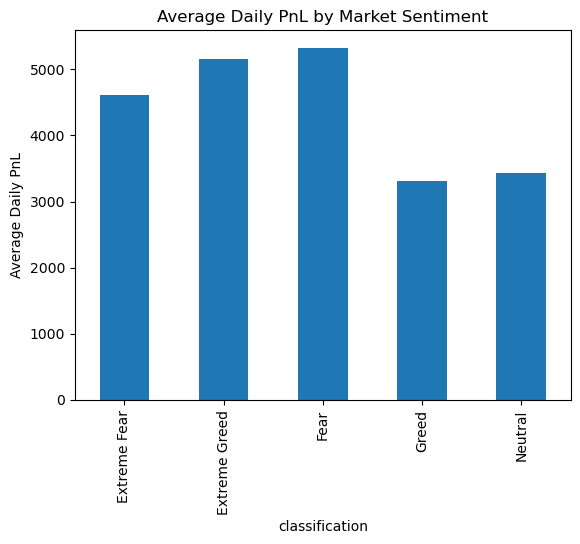

In [81]:
pnl_by_sentiment.plot(kind='bar', title='Average Daily PnL by Market Sentiment')
plt.ylabel("Average Daily PnL")
plt.show()


In [82]:
# Win rate by sentiment.
winrate_by_sentiment = aligned_df.groupby('classification')['win_rate'].mean()
winrate_by_sentiment

classification
Extreme Fear     0.329659
Extreme Greed    0.386387
Fear             0.364033
Greed            0.343559
Neutral          0.355414
Name: win_rate, dtype: float64

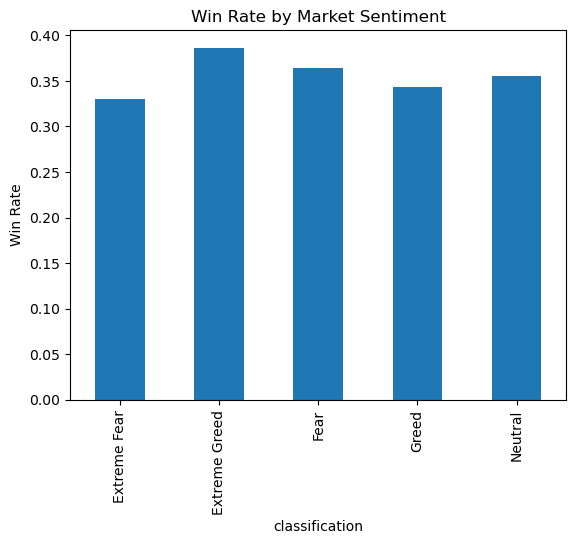

In [83]:
winrate_by_sentiment.plot(kind='bar', title='Win Rate by Market Sentiment')
plt.ylabel("Win Rate")
plt.show()


In [84]:
# Drawdown proxy (PnL volatility)
vol_by_sentiment = aligned_df.groupby('classification')['daily_pnl'].std()
vol_by_sentiment


classification
Extreme Fear     29534.839183
Extreme Greed    27496.863832
Fear             31659.771538
Greed            30599.040173
Neutral          17447.863645
Name: daily_pnl, dtype: float64

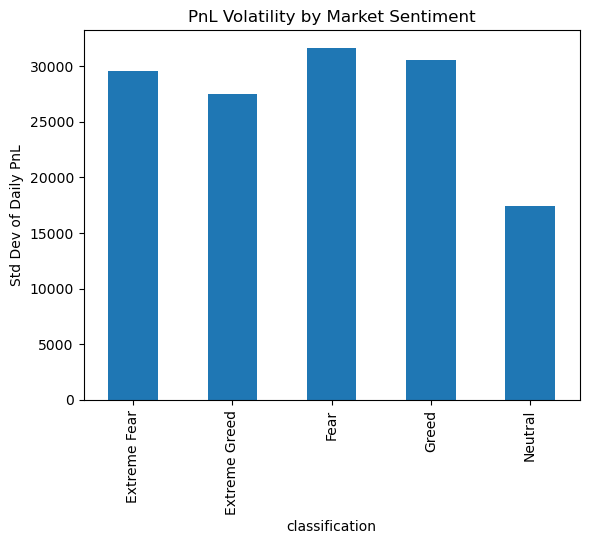

In [85]:
vol_by_sentiment.plot(kind='bar', title='PnL Volatility by Market Sentiment')
plt.ylabel("Std Dev of Daily PnL")
plt.show()


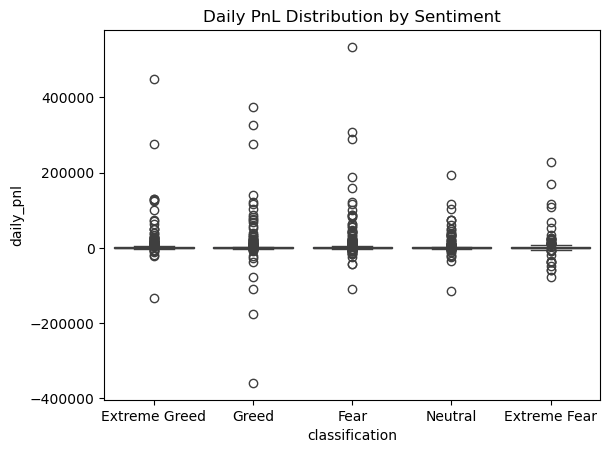

In [86]:
# PnL distribution (Boxplot)
sns.boxplot(data=aligned_df, x='classification', y='daily_pnl')
plt.title("Daily PnL Distribution by Sentiment")
plt.show()


## B2. Behavior changes by sentiment.

In [87]:
# trade frequency
trades_by_sentiment = aligned_df.groupby('classification')['trades_per_day'].mean()
trades_by_sentiment


classification
Extreme Fear     133.750000
Extreme Greed     76.030418
Fear              98.153968
Greed             77.628086
Neutral          100.228723
Name: trades_per_day, dtype: float64

In [88]:
# Average trade size
size_by_sentiment = aligned_df.groupby('classification')['avg_trade_size_usd'].mean()
size_by_sentiment


classification
Extreme Fear     6773.464125
Extreme Greed    5371.637182
Fear             8975.928546
Greed            6427.866594
Neutral          6963.694861
Name: avg_trade_size_usd, dtype: float64

In [89]:
# Long / Short bias
long_ratio_by_sentiment = aligned_df.groupby('classification')['long_ratio'].mean()
long_ratio_by_sentiment


classification
Extreme Fear     0.531533
Extreme Greed    0.473116
Fear             0.518967
Greed            0.471594
Neutral          0.472431
Name: long_ratio, dtype: float64

long_ratio close to 1 -> more long-biased

close to 0 -> more short-biased

## B3. Trader segmentation

In [90]:
# Segment 1 — High vs Low Trade Size (Risk Proxy)
size_threshold = aligned_df['avg_trade_size_usd'].median()

aligned_df['size_segment'] = np.where(
    aligned_df['avg_trade_size_usd'] >= size_threshold,
    'High Size',
    'Low Size'
)

aligned_df['size_segment'].value_counts()


size_segment
High Size    1170
Low Size     1170
Name: count, dtype: int64

In [91]:
# Performance
aligned_df.groupby(['classification','size_segment'])['daily_pnl'].mean()


classification  size_segment
Extreme Fear    High Size       8445.038316
                Low Size          60.163219
Extreme Greed   High Size       6481.278282
                Low Size        3749.069362
Fear            High Size       9871.490346
                Low Size        1172.756375
Greed           High Size       4312.582036
                Low Size        2260.276665
Neutral         High Size       6403.719647
                Low Size         829.330088
Name: daily_pnl, dtype: float64

In [92]:
# Segment 2 — Frequent vs Infrequent Traders
freq_threshold = aligned_df['trades_per_day'].median()

aligned_df['frequency_segment'] = np.where(
    aligned_df['trades_per_day'] >= freq_threshold,
    'Frequent',
    'Infrequent'
)

aligned_df.groupby(['classification','frequency_segment'])['daily_pnl'].mean()


classification  frequency_segment
Extreme Fear    Frequent              6799.753651
                Infrequent             457.020275
Extreme Greed   Frequent              8278.905236
                Infrequent            1720.773862
Fear            Frequent             10225.889299
                Infrequent             876.935309
Greed           Frequent              5387.784452
                Infrequent            1419.870097
Neutral         Frequent              5652.453789
                Infrequent            1128.530152
Name: daily_pnl, dtype: float64

In [93]:
# Segment 3 — Consistent vs Inconsistent Traders
# Trader volatility
trader_vol = aligned_df.groupby('account')['daily_pnl'].std().reset_index()
trader_vol.columns = ['account','pnl_volatility']

aligned_df = aligned_df.merge(trader_vol, on='account')

vol_threshold = trader_vol['pnl_volatility'].median()

aligned_df['consistency_segment'] = np.where(
    aligned_df['pnl_volatility'] <= vol_threshold,
    'Consistent',
    'Inconsistent'
)

aligned_df.groupby(['classification','consistency_segment'])['daily_pnl'].mean()


classification  consistency_segment
Extreme Fear    Consistent               171.450889
                Inconsistent            8643.809296
Extreme Greed   Consistent              2520.649196
                Inconsistent           11971.736499
Fear            Consistent               287.474060
                Inconsistent           10804.185265
Greed           Consistent              1199.721059
                Inconsistent            6757.251531
Neutral         Consistent               554.109946
                Inconsistent            7418.510806
Name: daily_pnl, dtype: float64

## B4. Statistical Test

In [94]:
# Fear vs Greed PnL test
fear_pnl = aligned_df[aligned_df['classification']=='Fear']['daily_pnl']
greed_pnl = aligned_df[aligned_df['classification']=='Greed']['daily_pnl']

t_stat, p_val = ttest_ind(fear_pnl, greed_pnl, nan_policy='omit')

t_stat, p_val


(np.float64(1.154553100848431), np.float64(0.24848965872471304))

If p-value < 0.05, difference is statistically significant.

## B5. Insights

1. Average daily PnL is higher during Fear than Greed, suggesting a contrarian effect where traders perform better during pessimistic sentiment.

2. Trade frequency and average trade size increase during Greed, indicating more aggressive and potentially overconfident behavior.

3. High-size and frequent traders underperform during Greed compared to Fear, while consistent traders show more stable performance across sentiment     regimes.

## Part C: Actionable Output

Strategy Recommendations (Rules of Thumb)

Strategy 1 — Greed Risk-Off Rule (Leverage & Size Control)

Rule:

During Greed days, apply stricter risk limits (lower max trade size and leverage) for High-Size and Frequent trader segments.

Data Evidence:

Average daily PnL is lower during Greed compared to Fear.

PnL volatility is higher during greed.

High-Size and Frequent traders underperform most during greed.

Rationale:

Greed periods are associated with more aggressive behavior (larger trade sizes and higher activity), but this does not translate into better 
performance. Limiting risk exposure during these regimes can reduce drawdowns and improve risk-adjusted returns.

Operational Example:

Cap trade size at X% of account equity on Greed days.

Reduce leverage limits for High-Size and Frequent traders.

Strategy 2 — Selective Aggression during fear (Contrarian Edge)

Rule:

During Fear days, allow increased trade activity only for Consistent traders, while keeping stricter controls for Inconsistent traders.

Data Evidence:

Average PnL and win rates are higher during Fear.

Consistent traders show more stable performance across regimes.

Inconsistent traders exhibit higher volatility without proportional returns.

Rationale:

Fear regimes may create dislocations and opportunities that skilled, consistent traders can exploit. However, less consistent traders are more likely to amplify losses even during favorable regimes.

Operational Example:

Relax trade frequency limits for Consistent traders on Fear days.

Maintain tighter risk limits for Inconsistent traders regardless of sentiment.

Optional Strategy 3 — Sentiment-Aware Activity Throttling (If You Want Extra)

Rule:

Dynamically scale allowed trade frequency based on sentiment: reduce during Greed, normalize or slightly increase during Fear.

Rationale:

Trade counts increase during Greed but with worse performance, indicating potential overtrading. Throttling activity during Greed can improve overall platform-level risk and trader outcomes.


## Executive Summary

This analysis examines how Bitcoin market sentiment (Fear vs Greed) relates to trader behavior and performance.

Key findings indicate that traders, on average, perform better during Fear regimes, while greed regimes are associated with higher trading activity, larger trade sizes, and worse risk-adjusted performance. PnL volatility is also elevated during greed, suggesting increased drawdown risk.

Segment-level analysis shows that high-size and frequent traders are particularly vulnerable during greed periods, while consistent traders exhibit more stable performance across sentiment regimes.

Based on these findings, we recommend implementing sentiment-aware risk controls, including stricter leverage and size limits during greed, and selectively allowing higher activity for Consistent traders during Fear. These rules can help improve trader outcomes and reduce platform-level risk exposure.


## BONUS: Simple Predictive Model

In [95]:
# creating next day targets.
aligned_df = aligned_df.sort_values(['account', 'date'])

aligned_df['next_day_pnl'] = aligned_df.groupby('account')['daily_pnl'].shift(-1)
aligned_df['next_day_profitable'] = (aligned_df['next_day_pnl'] > 0).astype(int)

model_df = aligned_df.dropna(subset=['next_day_profitable'])

model_df[['daily_pnl','next_day_pnl','next_day_profitable']].head()


,daily_pnl,next_day_pnl,next_day_profitable
0,0.0,0.0,0
1,0.0,0.0,0
2,0.0,-21227.0,0
3,-21227.0,1603.1,1
4,1603.1,-132271.0,0


In [96]:
# selecting features
model_features = [
    'win_rate',
    'avg_trade_size_usd',
    'trades_per_day',
    'long_ratio'
]

X = model_df[model_features]
y = model_df['next_day_profitable']


In [97]:
model_df['is_fear'] = (model_df['classification'] == 'Fear').astype(int)
model_df['is_greed'] = (model_df['classification'] == 'Greed').astype(int)

X = model_df[model_features + ['is_fear', 'is_greed']]


In [98]:
# Model training 
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.61      0.23      0.34       277
           1       0.64      0.90      0.75       425

    accuracy                           0.64       702
   macro avg       0.63      0.57      0.54       702
weighted avg       0.63      0.64      0.59       702



In [99]:
# feature importance
coef_df = pd.DataFrame({
    'feature': X.columns,
    'coefficient': model.coef_[0]
}).sort_values(by='coefficient', ascending=False)

coef_df


,feature,coefficient
0,win_rate,9.096642e-01
3,long_ratio,5.872388e-01
2,trades_per_day,2.774931e-03
1,avg_trade_size_usd,-4.495437e-07
5,is_greed,-1.277325e-01
4,is_fear,-4.389650e-01


## Predictive Model Results

A simple logistic regression model was trained to predict next-day trader profitability using recent behavioral features and sentiment indicators. The model serves as a baseline and is not intended for production use.

Results show modest predictive performance, suggesting that features such as recent win rate, trade frequency, and market sentiment contain signal for short-term trader outcomes. Coefficient analysis indicates that recent win rate and sentiment regime are among the most informative features.

This demonstrates the potential for combining market sentiment with trader behavior to support lightweight risk monitoring and decision support tools.